In [55]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import sys
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, LSTM
from keras.regularizers import l1, l2



%matplotlib inline

# Global Var
sliding_window_size = 10

In [6]:
full_data = pd.read_csv('../../data/train.csv')
test_data = pd.read_csv('../../data/test.csv')

In [7]:
def chunk_data(data, number_of_chunks):
    chunks = list()
    lst = np.linspace(0, len(data), number_of_chunks + 1, dtype = int)
    for start, stop in zip(lst[0:-1], lst[1:]):
        chunks.append(data[start:stop].copy())
    return chunks

def linear_transform(data, slope, intercept):
    data = data.copy()
    data['signal'] = data['signal'] - (slope * data['time'] + intercept)
    return data

def parabolic_transform(data, h, k):
    '''
    vertex formula of parabola (a * (x- h) ^ 2 + k)
    a is the steepnes (same as a in standard form)
    h is the x value of the vertex (time of the center of the chunk)
    k is the y value of the vertex
    
    a = -k / 625
    '''
    data = data.copy()
    data['signal'] = data['signal'] - ((-k / 625) * (data['time'] - h) ** 2 + k)
    return data

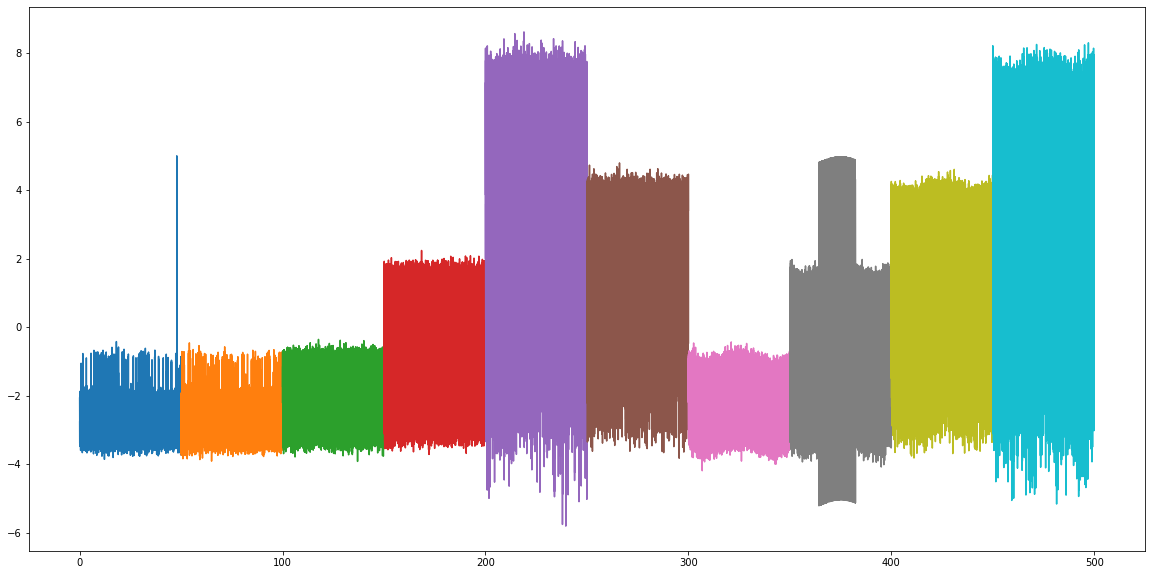

In [8]:
train_chunks = chunk_data(full_data, 10)

train_chunks[1][:100000] = linear_transform(train_chunks[1][:100000], 3 / 10, -15)
train_chunks[6] = parabolic_transform(train_chunks[6], 325, 5.003)
train_chunks[7] = parabolic_transform(train_chunks[7], 375, 5.030)
train_chunks[8] = parabolic_transform(train_chunks[8], 425, 4.974)
train_chunks[9] = parabolic_transform(train_chunks[9], 475, 5.089)

plt.figure(figsize = (20, 10))
for i in train_chunks:
    plt.plot(i['time'], i['signal'])

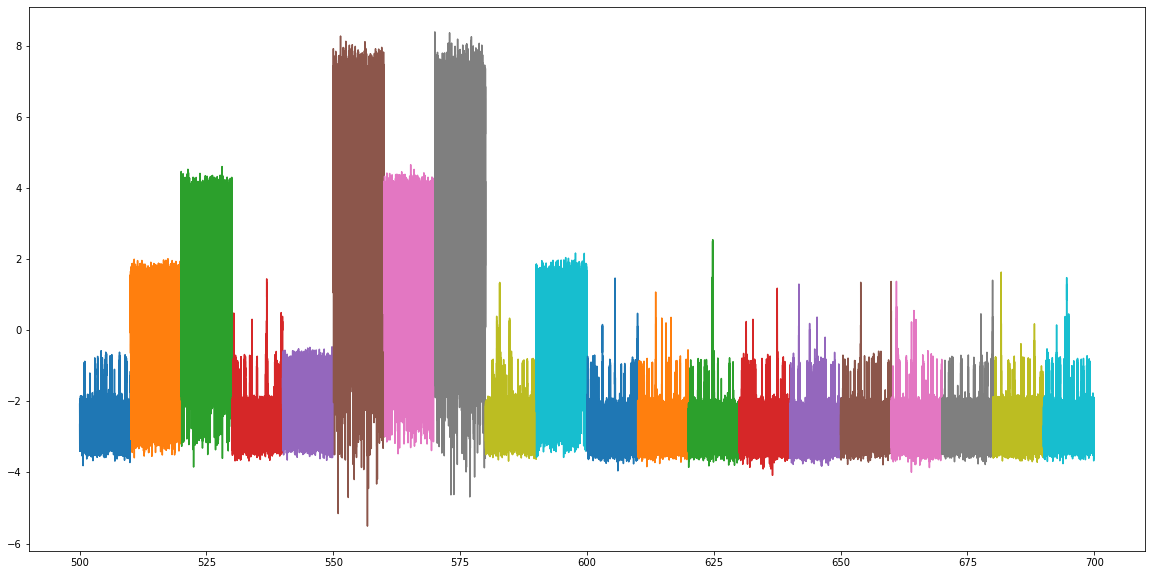

In [9]:
test_chunks = chunk_data(test_data, 4)
test_chunks = chunk_data(test_chunks[0], 5) + chunk_data(test_chunks[1], 5) + test_chunks[2:]

test_chunks[0] = linear_transform(test_chunks[0], 3 / 10, -150)
test_chunks[1] = linear_transform(test_chunks[1], 3 / 10, -153)
test_chunks[4] = linear_transform(test_chunks[4], 3 / 10, -162)
test_chunks[6] = linear_transform(test_chunks[6], 3 / 10, -168)
test_chunks[7] = linear_transform(test_chunks[7], 3 / 10, -171)
test_chunks[8] = linear_transform(test_chunks[8], 3 / 10, -174)
test_chunks[10] = parabolic_transform(test_chunks[10], 625, 4.925)
test_chunks[10]['signal'] -= test_chunks[10]['time'].apply(lambda x: - 0.15 * math.sin(math.pi * 3 * x / 50))

test_chunks = test_chunks[:10] + chunk_data(pd.concat(test_chunks[10:]), 10)

plt.figure(figsize = (20, 10))
for i in test_chunks:
    plt.plot(i['time'], i['signal'])

In [39]:
def _sliding_window(array, window_size, offset = 0):
    """
    offset = number of zeros added to the begining 
    """
    array = np.append(np.append(np.zeros(offset), array), np.zeros(window_size - offset))
    sliding_window_array = [array[0: -window_size]]
    for i in range(1, window_size):
        sliding_window_array = np.append(sliding_window_array, [array[i:i - window_size]], axis = 0)
    return sliding_window_array.T

def make_sliding_window(series, window_size):
    col_names = [series.name + str(i) for i in range(window_size)]
    return pd.DataFrame(_sliding_window(series, window_size, window_size // 2), columns = col_names)

def make_sliding_window_frame(data, window_size):
    sliding_window = make_sliding_window(data['signal'], window_size)
    sliding_window['open_channels'] = data['open_channels'].reset_index(drop = True)
    return sliding_window

In [56]:
a = pd.concat([train_chunks[0], train_chunks[1]])
make_sliding_window_frame(a, 10)

model5_data = pd.concat([train_chunks[4], train_chunks[9]])
model5_data = make_sliding_window_frame(model5_data, sliding_window_size)
model5_data

,signal0,signal1,signal2,signal3,signal4,signal5,signal6,signal7,signal8,signal9,open_channels
0,0.000000,0.000000,0.000000,0.000000,0.000000,7.119100,6.771200,6.927800,7.354100,7.4194,10
1,0.000000,0.000000,0.000000,0.000000,7.119100,6.771200,6.927800,7.354100,7.419400,7.6610,10
2,0.000000,0.000000,0.000000,7.119100,6.771200,6.927800,7.354100,7.419400,7.661000,6.5489,10
3,0.000000,0.000000,7.119100,6.771200,6.927800,7.354100,7.419400,7.661000,6.548900,6.0989,10
4,0.000000,7.119100,6.771200,6.927800,7.354100,7.419400,7.661000,6.548900,6.098900,6.6409,10
...,...,...,...,...,...,...,...,...,...,...,...
999995,4.507934,3.387374,2.348115,4.191256,4.371096,2.919237,2.697878,4.516319,5.639659,5.3792,7
999996,3.387374,2.348115,4.191256,4.371096,2.919237,2.697878,4.516319,5.639659,5.379200,0.0000,7
999997,2.348115,4.191256,4.371096,2.919237,2.697878,4.516319,5.639659,5.379200,0.000000,0.0000,8
999998,4.191256,4.371096,2.919237,2.697878,4.516319,5.639659,5.379200,0.000000,0.000000,0.0000,9


In [40]:
#'''
def get_model(data):
    model = Sequential()
    model.add(Dense(22, input_dim = 10, activation = 'relu'))
    model.add(Dense(33, activation = 'relu'))
    model.add(Dense(44, activation = 'relu'))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(data.drop(['open_channels'], axis = 1), data['open_channels'], batch_size = 100, epochs = 10, validation_split = 0.4)
    return model
#'''

'''
def get_model(data, time_window_size):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',
                         input_shape=(time_window_size, 1)))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Dense(units = time_window_size, activation='linear'))
    model.add(Dense(time_window_size * 2, activation = 'relu'))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
#'''

'''
def get_modelx(data, time_window_size):
    model = Sequential()
    model.add(LSTM(time_window_size * 10, input_shape  = (1, time_window_size)))
    model.add(Dense(40, activation = 'relu', kernel_regularizer = l2(0.01)))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
#''';

In [41]:
model1_data = pd.concat([train_chunks[0], train_chunks[1]])
model1_data = make_sliding_window_frame(model1_data, sliding_window_size)

model2_data = pd.concat([train_chunks[2], train_chunks[6]])
model2_data = make_sliding_window_frame(model2_data, sliding_window_size)

model3_data = pd.concat([train_chunks[3], train_chunks[7]])
model3_data = make_sliding_window_frame(model3_data, sliding_window_size)

model4_data = pd.concat([train_chunks[5], train_chunks[8]])
model4_data = make_sliding_window_frame(model4_data, sliding_window_size)

model5_data = pd.concat([train_chunks[4], train_chunks[9]])
model5_data = make_sliding_window_frame(model5_data, sliding_window_size)

In [49]:
model5_data

,signal0,signal1,signal2,signal3,signal4,signal5,signal6,signal7,signal8,signal9,open_channels
0,0.000000,0.000000,0.000000,0.000000,0.000000,7.119100,6.771200,6.927800,7.354100,7.4194,10
1,0.000000,0.000000,0.000000,0.000000,7.119100,6.771200,6.927800,7.354100,7.419400,7.6610,10
2,0.000000,0.000000,0.000000,7.119100,6.771200,6.927800,7.354100,7.419400,7.661000,6.5489,10
3,0.000000,0.000000,7.119100,6.771200,6.927800,7.354100,7.419400,7.661000,6.548900,6.0989,10
4,0.000000,7.119100,6.771200,6.927800,7.354100,7.419400,7.661000,6.548900,6.098900,6.6409,10
...,...,...,...,...,...,...,...,...,...,...,...
999995,4.507934,3.387374,2.348115,4.191256,4.371096,2.919237,2.697878,4.516319,5.639659,5.3792,7
999996,3.387374,2.348115,4.191256,4.371096,2.919237,2.697878,4.516319,5.639659,5.379200,0.0000,7
999997,2.348115,4.191256,4.371096,2.919237,2.697878,4.516319,5.639659,5.379200,0.000000,0.0000,8
999998,4.191256,4.371096,2.919237,2.697878,4.516319,5.639659,5.379200,0.000000,0.000000,0.0000,9


In [50]:
model1 = get_model(model1_data)
model2 = get_model(model2_data)
model3 = get_model(model3_data)
model4 = get_model(model4_data)
model5 = get_model(model5_data)

Train on 600000 samples, validate on 400000 samples
Epoch 1/10
600000/600000 [==============================] - 7s 11us/step - loss: 0.0158 - accuracy: 0.9950 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 2/10
600000/600000 [==============================] - 7s 11us/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 3/10
600000/600000 [==============================] - 7s 11us/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0016 - val_accuracy: 0.9994
Epoch 4/10
600000/600000 [==============================] - 7s 11us/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0013 - val_accuracy: 0.9995
Epoch 5/10
600000/600000 [==============================] - 7s 11us/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0022 - val_accuracy: 0.9992
Epoch 6/10
600000/600000 [==============================] - 7s 11us/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0013 - val_accuracy: 0.9996
Epoch 7/10
600000/600000 [============================

In [82]:
def predict(model, test_data):
    y_predictions = model.predict_classes(make_sliding_window(test_data['signal'], sliding_window_size))
    return pd.DataFrame({'time' : test_data['time'].values, 'open_channels' : y_predictions})

In [83]:
predictions = pd.DataFrame(columns = ['time', 'open_channels'])
predictions = pd.concat([predictions, predict(model1, test_chunks[0])])
predictions = pd.concat([predictions, predict(model3, test_chunks[1])])
predictions = pd.concat([predictions, predict(model4, test_chunks[2])])
predictions = pd.concat([predictions, predict(model1, test_chunks[3])])
predictions = pd.concat([predictions, predict(model2, test_chunks[4])])
predictions = pd.concat([predictions, predict(model5, test_chunks[5])])
predictions = pd.concat([predictions, predict(model4, test_chunks[6])])
predictions = pd.concat([predictions, predict(model5, test_chunks[7])])
predictions = pd.concat([predictions, predict(model1, test_chunks[8])])
predictions = pd.concat([predictions, predict(model3, test_chunks[9])])
predictions = pd.concat([predictions, predict(model1, test_chunks[10])])
predictions = pd.concat([predictions, predict(model1, test_chunks[11])])
predictions = pd.concat([predictions, predict(model1, test_chunks[12])])
predictions = pd.concat([predictions, predict(model1, test_chunks[13])])
predictions = pd.concat([predictions, predict(model1, test_chunks[14])])
predictions = pd.concat([predictions, predict(model1, test_chunks[15])])
predictions = pd.concat([predictions, predict(model1, test_chunks[16])])
predictions = pd.concat([predictions, predict(model1, test_chunks[17])])
predictions = pd.concat([predictions, predict(model1, test_chunks[18])])
predictions = pd.concat([predictions, predict(model1, test_chunks[19])])

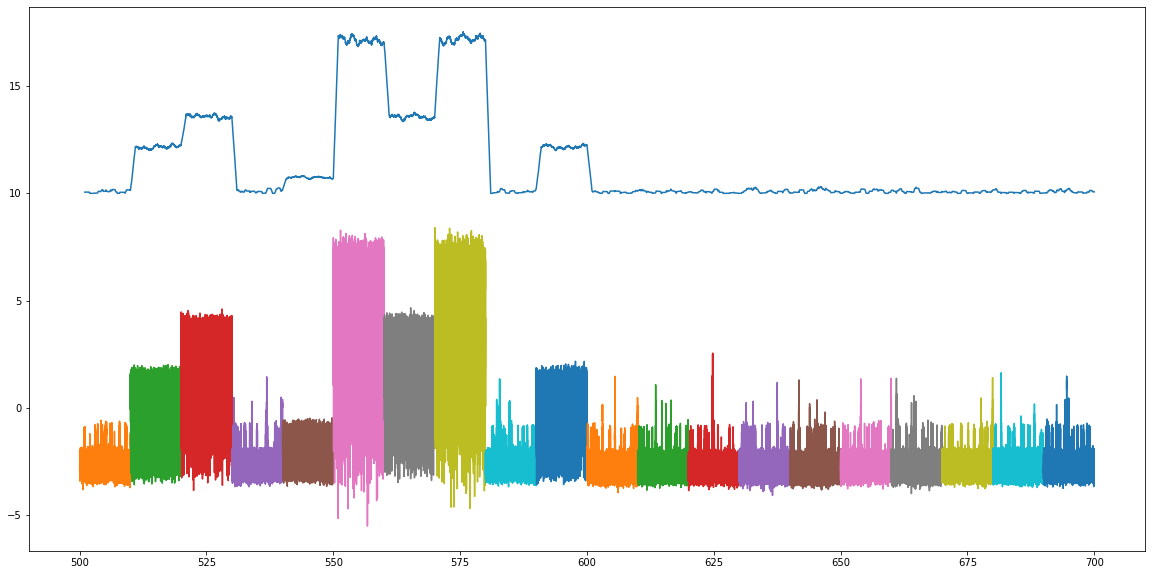

In [84]:
plt.figure(figsize = (20, 10))
plt.plot(predictions['time'], predictions['open_channels'].rolling(10000).mean() + 10)
for i in test_chunks:
    plt.plot(i['time'], i['signal'])

In [86]:
predictions.to_csv('~/Desktop/test_predictions.csv', index = False, float_format='%.4f')
#0.936

In [236]:
model5 = get_model(model5_data)
y =  model5_data['open_channels']
X = model5_data.drop(['open_channels'], axis = 1)
#X = X.to_numpy().reshape((X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [239]:
history = model5.fit(X_train, y_train, batch_size = 100, epochs = 5, validation_split = 0.4)

Train on 450000 samples, validate on 300000 samples
Epoch 1/5
450000/450000 [==============================] - 5s 12us/step - loss: 0.3354 - accuracy: 0.8652 - val_loss: 0.3276 - val_accuracy: 0.8683
Epoch 2/5
450000/450000 [==============================] - 5s 12us/step - loss: 0.3341 - accuracy: 0.8660 - val_loss: 0.3286 - val_accuracy: 0.8677
Epoch 3/5
450000/450000 [==============================] - 5s 12us/step - loss: 0.3330 - accuracy: 0.8663 - val_loss: 0.3267 - val_accuracy: 0.8686
Epoch 4/5
450000/450000 [==============================] - 5s 12us/step - loss: 0.3325 - accuracy: 0.8662 - val_loss: 0.3416 - val_accuracy: 0.8614
Epoch 5/5
450000/450000 [==============================] - 5s 12us/step - loss: 0.3314 - accuracy: 0.8670 - val_loss: 0.3364 - val_accuracy: 0.8651


In [240]:
f1_score(y_test, model5.predict_classes(X_test), average = 'macro')

0.8477729903969655

In [143]:
model5.predict_classes(X_test)

array([10,  8,  8, ...,  7,  6,  5])

In [11]:
sys.getsizeof(frame) // 1000000

88